# Tutorial 03: Implementing an interpolation module for an X-ray component to allow gradient descent

## Introduction

This tutorial covers how to implement an interpolation module for an X-ray component to enable **gradient-based optimization**. Analytical models are often **not reliable** for accurately modeling X-ray sources due to complex interactions in the system. Instead, we can use an **interpolation model** with some lookup tables to achieve a more accurate and flexible representation.

Many physics-based models, such as X-ray source modeling, rely on **lookup tables** generated using particle simulation tool like **Geant4**. 

We use **linear interpolation** to create a continuous function based on the lookup table values. This approach ensures that the function is **numerically differentiable**, allowing for **gradient descent optimization**.

### **What You Will Need**
- **User adjustable Parameters**: $v$ is known, like source voltage.
- **Estimated Parameters**: $a, b, c, \dots$ to be estimated or optimized.  
- **An interpolation model**: $S(E, v; a, b, c, \dots)$ that defines the spectrum or energy response.  
- **Lookup table**: Precomputed values stored as  

  $$
  \mathcal{S}[E, v; i_a, i_b, i_c, \dots]
  $$

  where:
  - $E$ represents photon energy.
  - $v$ represents source voltage.
  - $i_a, i_b, i_c, \dots$ are discrete indices for model parameters $a, b, c, \dots$.  

- **Interpolation**: Used to approximate intermediate values between the discrete lookup table entries, ensuring smooth optimization.  

### **What You Will Expect**
- How to build an **interpolation-based model**?
- Implementing the model using **PyTorch** for differentiability.
- A step-by-step guide to setting up and testing the interpolation module.

## A. Interpolation Model of Transmission Source
### A1. Background

For a transmission X-ray source, target thickness $\theta^s$ is essential for the X-ray source spectrum. We want to estimate this parameter.
For a given parameter $\theta^s$ between two discrete points $\theta_q^s$ and $\theta_{q+1}^s$, we approximate the function as:

$$
S (E, v; \theta^s) = (1 - \gamma) \mathcal{S}(E, v; \theta_q^s) + \gamma \mathcal{S}(E,\theta_{q+1}^s)
$$

where the interpolation weight $\gamma$ is given by:

$$
\gamma = \frac{\theta^s - \theta_q^s}{\theta_{q+1}^s - \theta_q^s}, \quad \text{for } \theta_q^s \leq \theta^s < \theta_{q+1}^s.
$$

This interpolation provides a **smooth approximation** of the function and is **numerically differentiable**, except at the discrete lookup points. 


### A2. Step-by Step Implementation

To build an interpolation model that supports **gradient descent**, we need three key functions:

1. **`__init__` (Initialize the Model)**  
   - Defines **voltage** as adjustable parameter and **target thickness** as optimizable parameters.  
   - Supports **single target thickness** for the CT system. If set to true, all instances of this class will use the same target thickness.   

2. **`set_src_spec_list` (Setup Lookup Table & Interpolation)**  
   - Loads **lookup table data**: discrete energies, spectra, voltages, and thicknesses.  
   - Interpolation spectrum over source voltage. 
   - Uses **bilinear interpolation (`Interp2D`)** to smoothly estimate spectra between discrete points.  

3. **`forward` (Compute Interpolated Spectrum)**  
   - Retrieves **current model parameters**.  
   - Applies **2D interpolation** on voltage and target thickness. 
   - Applies **1D interpolation (`Interp1D`)** for input energy.  
   - Ensures a **continuous, differentiable function** for **gradient-based optimization**.  

This setup enables **efficient spectral modeling and optimization** using PyTorch.  


#### **Note 1: Handling Continuous Parameters in Optimization**
In the `Transmission_Source` class, we define **voltage** and **target thickness** as optimizable parameters. These parameters are provided as tuples:  

- **`voltage`**: `(initial value, lower bound, upper bound)`  
- **`target_thickness`**: `(initial value, lower bound, upper bound)`  

##### **Key Constraints:**
- **All three values cannot be `None`**, ensuring the parameter is properly defined.
- If **lower bound == upper bound**, the parameter is **fixed** and will **not be optimized**.

To handle these parameters, we store them in a dictionary and pass them to the base class:

```python
# Build dictionary for continuous parameters
params_list = [{'voltage': voltage, 'target_thickness': target_thickness}]
super().__init__(params_list)


#### **Note 2: Handling Data Conversion in `set_src_spec_list`**  

In `set_src_spec_list`, we carefully transition data from **lists → NumPy arrays → Torch tensors** to ensure compatibility with **PyTorch's function**. 


In [1]:
import numpy as np
import torch
from xcal.models import Base_Spec_Model, prepare_for_interpolation, Interp1D, Interp2D

class Transmission_Source(Base_Spec_Model):
    def __init__(self, voltage, target_thickness, single_target_thickness):
        """
        A template source model designed specifically for reflection sources, including all necessary methods.

        Args:
            voltage (tuple): (initial value, lower bound, upper bound) for the source voltage.
                These three values cannot be all None. It will not be optimized when lower == upper.
            target_thickness (tuple): (initial value, lower bound, upper bound) for the target thickness.
                These three values cannot be all None. It will not be optimized when lower == upper.
            single_target_thickness (bool): If ture, all instances of class transmission source will be the same.
            
        """
        # Build dictionary for continous parameter.
        params_list = [{'voltage': voltage, 'target_thickness': target_thickness}]
        super().__init__(params_list)
        
        self.single_target_thickness = single_target_thickness
        if self.single_target_thickness:
            for params in self._params_list:
                params[f"{self.__class__.__name__}_target_thickness"] = params.pop(f"{self.prefix}_target_thickness")
            self._init_estimates()

    def set_src_spec_list(self, energies, src_spec_list, voltages, target_thicknesses):
        """Set source spectra for interpolation, which will be used only by forward function.

        Args:
            src_spec_list (numpy.ndarray): This array contains the reference X-ray source spectra. Each spectrum in this array corresponds to a specific combination of the target_thicknesses and one of the source voltages from src_voltage_list.
            src_voltage_list (numpy.ndarray): This is a sorted array containing the source voltages, each corresponding to a specific reference X-ray source spectrum.
            target_thicknesses (float): This value represents the target_thicknesses, expressed in um, which is used in generating the reference X-ray spectra.
        """
        # Load data
        self.energies = torch.tensor(energies, dtype=torch.float32)
        self.src_spec_list = np.array(src_spec_list)
        self.voltages = np.array(voltages)
        self.target_thicknesses = np.array(target_thicknesses)
        modified_src_spec_list = src_spec_list.copy()
        
        # Interpolation spectrum over source voltage. 
        for tti, tt in enumerate(target_thicknesses):
            modified_src_spec_list[:, tti] = prepare_for_interpolation(modified_src_spec_list[:, tti])

        # Bilinear interpolation
        V, T = torch.meshgrid(torch.tensor(self.voltages, dtype=torch.float32), torch.tensor(self.target_thicknesses, dtype=torch.float32), indexing='ij')
        self.src_spec_interp_func = Interp2D(V, T, torch.tensor(modified_src_spec_list, dtype=torch.float32))

    def forward(self, energies):
        """
        Takes X-ray energies and returns the source spectrum.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The source response.
        """
        #  Retrieves voltage and target thickness
        voltage = self.get_params()[f"{self.prefix}_voltage"]
        if self.single_target_thickness:
            target_thickness = self.get_params()[f"{self.__class__.__name__}_target_thickness"]
        else:
            target_thickness = self.get_params()[f"{self.prefix}_target_thickness"]
        
        # Applies 2D interpolation on voltage and target thickness. 
        src_spec = self.src_spec_interp_func(voltage, target_thickness)
        
        # Build 1D interpolation function with src_spec. 
        src_interp_E_func = Interp1D(self.energies, src_spec)
        
        # Applies 1D interpolation function for input energy. 
        energies = torch.tensor(energies, dtype=torch.float32) if not isinstance(energies, torch.Tensor) else energies
        return src_interp_E_func(energies)

## A3. Usage of Transmission Source

In [2]:
import pandas as pd

def integrate_by_step(data, step_size, offset=0):
    num_elements = len(data)

    # Calculate the number of chunks
    num_chunks = (num_elements // step_size) + (1 if num_elements % step_size else 0)

    # Generate the chunks and sum their elements
    integrated_data = [sum(data[i*step_size-offset : (i)*step_size+step_size-offset]) for i in range(num_chunks)]
    
    return np.array(integrated_data)    

psize = 0.01 # mm
max_simkV=150
energies_lookup = np.linspace(1, max_simkV, max_simkV) 

# Define the kVp and Wth values for the lookup table
kvp_values = [40, 80, 150]
wth_values = [1, 3, 5, 7]

# Read data from lookup table.
data = []
df = pd.read_csv('./data/lookup_tables/Geant4_Transmission_Source_Spectra.csv', header=[0,1,2,3,4,5])
df.columns.set_names(['W_Thickness', 'Diamond_Thickness', 'Angle', 'PhysicsModel', 'Voltage', 'Energy (keV)'], inplace=True)

# Prepare lookup table data for set_src_spec_list.
for kvp in kvp_values:
    wth_data = []
    for wth in wth_values:
        # Load the data, skipping the first row
        # Specify which spectrum is read from the large csv file based on Target thickness, Apex Angle, Physics Model in Geant4, and Source Voltage.
        csv_data = df.xs(('%dum'%wth,
                          '10deg',
                          'G4EmLivermorePhysics', 
                          '%dkVp'%kvp), 
                         level=['W_Thickness', 'Angle','PhysicsModel','Voltage'], axis=1)*psize*psize
        # Convert bin size from 0.1 keV to 1 keV.
        sp_integral = integrate_by_step(csv_data.values[9:,0],step_size=10,offset=5)
        # Append only the y-axis data (second column)
        wth_data.append(sp_integral)


    # Stack the Wth data for this particular kVp
    data.append(np.array(wth_data))

# Convert the list to a 3D numpy array
padded_spec_table = np.array(data)
print('Lookup Table has dimension:', padded_spec_table.shape)
print(f'{len(kvp_values)}  source voltages')
print(f'{len(wth_values)}  target thicknesses')
print(f'{len(energies_lookup)}  energy bins')
padded_spec_table = np.pad(padded_spec_table, ((0, 0), (0, 0), (0, 10)), mode='constant', constant_values=0)

Lookup Table has dimension: (3, 4, 150)
3  source voltages
4  target thicknesses
150  energy bins


### What will get from this example?

* A differentiable function for the transmission source, $S (E, v; \theta^s)$, which depends on the source voltage and target thickness, and outputs a one-dimensional source spectrum corresponding to the energy vector.

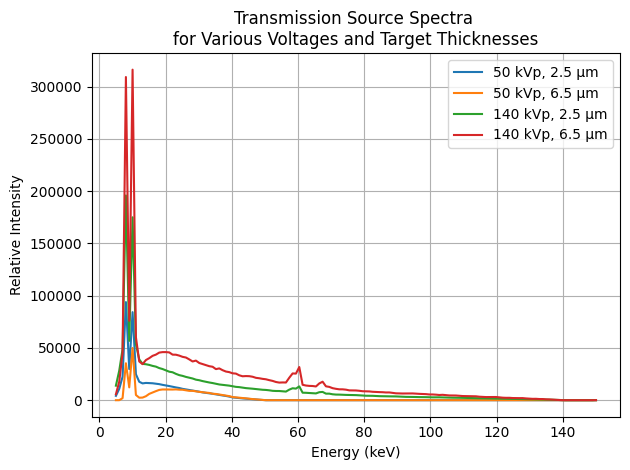

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define energy vector for output.
ee = np.linspace(5, 150, 145)

# Define parameter combinations of source voltage (kVp) and tungsten target thickness (μm)
param_combinations = [
    {'voltage': 50, 'thickness': 2.5},
    {'voltage': 50, 'thickness': 6.5},
    {'voltage': 140, 'thickness': 2.5},
    {'voltage': 140, 'thickness': 6.5},
]

# Plot spectra for each combination
for combo in param_combinations:
    v = combo['voltage']
    theta_s = combo['thickness']
    
    # Initialize the transmission source
    source = Transmission_Source(
        voltage=(v, None, None),
        target_thickness=(theta_s, 1, 7),
        single_target_thickness=True
    )
    
    # Set the source spectrum list
    source.set_src_spec_list(energies_lookup, padded_spec_table, kvp_values, wth_values)
    
    # Compute the spectrum
    ss = source(ee)
    
    # Plot the spectrum with a label
    plt.plot(ee, ss.data, label=f'{v} kVp, {theta_s} μm')

# Customize the plot
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Transmission Source Spectra \nfor Various Voltages and Target Thicknesses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# B. An Example of Estimating Target Thickness.

## B1. Data Simulation

In [4]:
from xcal import get_filter_response,get_scintillator_response
from xcal.chem_consts._periodictabledata import density

gt_src_tgt_th = 4.5 # micrometer
vol_list = [40, 80, 150] # kV

fltr_mat = 'Al' # filter material
fltr_th = 3 # filter thickness in mm

det_mat = 'CsI' # scintillator material
det_density = 4.51 # scintillator density g/cm^3
det_th = 0.33 # scintillator thickness in mm

# For generating ground truth, set min and max to None for disable optimization.
src_modules = [Transmission_Source(
        voltage=(v, None, None),
        target_thickness=(gt_src_tgt_th, None, None), 
        single_target_thickness=True
    ) for v in vol_list]

[source.set_src_spec_list(energies_lookup, padded_spec_table, kvp_values, wth_values) for source in src_modules]
gt_srcs = [source(ee) for source in src_modules]
gt_fltr = get_filter_response(ee, fltr_mat, density[fltr_mat], fltr_th)
gt_det = get_scintillator_response(ee, det_mat, det_density, det_th)

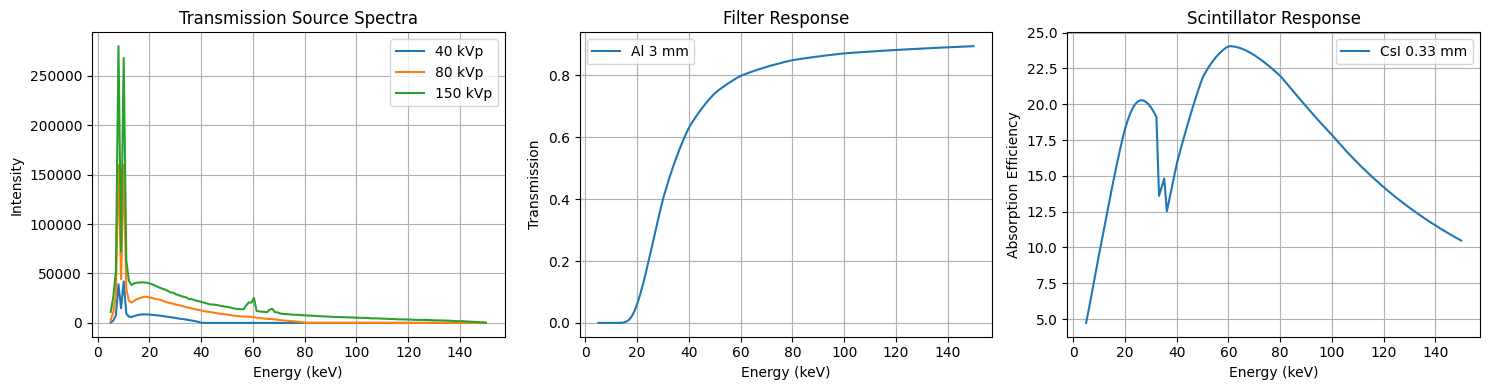

In [5]:
import matplotlib.pyplot as plt

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subplot 1: Source spectra for different voltages
for i, (v, spec) in enumerate(zip(vol_list, gt_srcs)):
    axes[0].plot(ee, spec.data, label=f'{v} kVp')
axes[0].set_title('Transmission Source Spectra')
axes[0].set_xlabel('Energy (keV)')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Filter response
axes[1].plot(ee, gt_fltr, label=f'{fltr_mat} {fltr_th} mm')
axes[1].set_title('Filter Response')
axes[1].set_xlabel('Energy (keV)')
axes[1].set_ylabel('Transmission')
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Scintillator response
axes[2].plot(ee, gt_det, label=f'{det_mat} {det_th} mm')
axes[2].set_title('Scintillator Response')
axes[2].set_xlabel('Energy (keV)')
axes[2].set_ylabel('Absorption Efficiency')
axes[2].legend()
axes[2].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

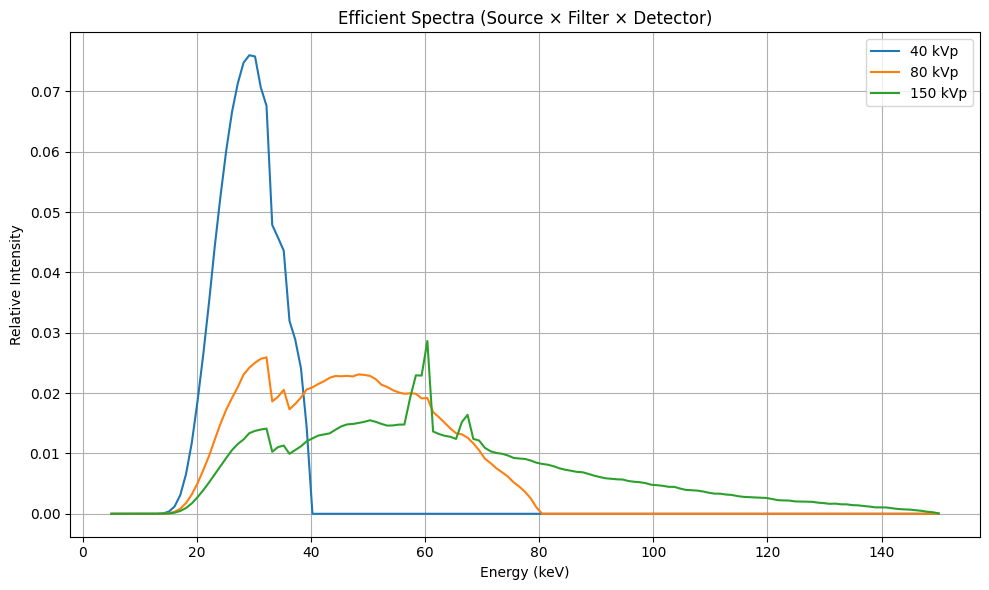

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ee, gt_srcs, gt_fltr, gt_det, and vol_list are already defined

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))
gt_spec_list = []
# Plot the efficient spectra for each voltage
for v, spec in zip(vol_list, gt_srcs):
    # Convert spec.data to a NumPy array if it's not already
    spectrum = np.asarray(spec.data)
    # Calculate the efficient spectrum by multiplying with filter and detector responses. 
    # Then do normalization.
    efficient_spectrum = spectrum * gt_fltr * gt_det
    gt_spec_list.append(efficient_spectrum)
    # efficient_spectrum/=np.trapezoid(efficient_spectrum)
    # Plot the efficient spectrum
    plt.plot(ee, efficient_spectrum/np.trapezoid(efficient_spectrum), label=f'{v} kVp')

# Add labels and title
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Efficient Spectra (Source × Filter × Detector)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from xcal.chem_consts import get_lin_att_c_vs_E
sample_mats = ['V', 'Al', 'Ti', 'Mg']
mat_density = [density[formula] for formula in sample_mats]
lac_vs_E_list = [get_lin_att_c_vs_E(den, formula, ee) for den, formula in zip(mat_density, sample_mats)]
sample_thicknesses = np.linspace(0, 1, 100) # mm

# Attenuation Matrix, multiply effective spectrum can obtain tranmission measurement.
# (4*100)*145: 4 materials, 100 different thicknesses, at total 400 measurements and 145 energy bins.
spec_F = np.concatenate([np.exp(-sample_thicknesses[:,np.newaxis]@lac_vs_E[np.newaxis]) for lac_vs_E in lac_vs_E_list],axis=0)

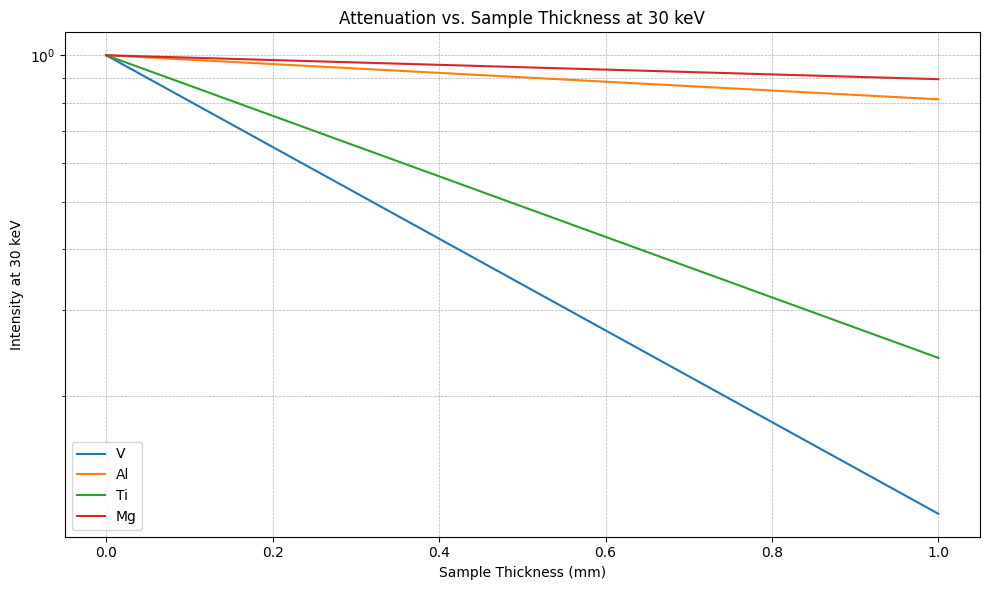

In [8]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the data for each sample material
for smid, sample_mat in enumerate(sample_mats):
    plt.plot(sample_thicknesses, spec_F[100*smid:100*(smid+1), 30], label=sample_mat)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Sample Thickness (mm)')
plt.ylabel('Intensity at 30 keV')
plt.title('Attenuation vs. Sample Thickness at 30 keV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [9]:
trans_list = []
for case_i, gt_spec in zip(np.arange(len(gt_spec_list)), gt_spec_list):
    # Obtain the converted energy, which is proportional to the detected visible light photons by the camera.
    # gt_spec is the converted energy without an object.
    # Notice that, trapezoid does the energy integration.
    trans = np.trapezoid(spec_F * gt_spec, ee, axis=-1) # Object scan
    trans_0 = np.trapezoid(gt_spec, ee, axis=-1) # Air scan value
    # Add poisson noise.
    # The noise level can be adjusted by changing the mas, the current-time product in the beginning of this tutorial.
    trans_noise = np.random.poisson(trans).astype(np.float32)
    trans_noise /= trans_0

    # Store noisy transmission data.
    trans_list.append(trans_noise)

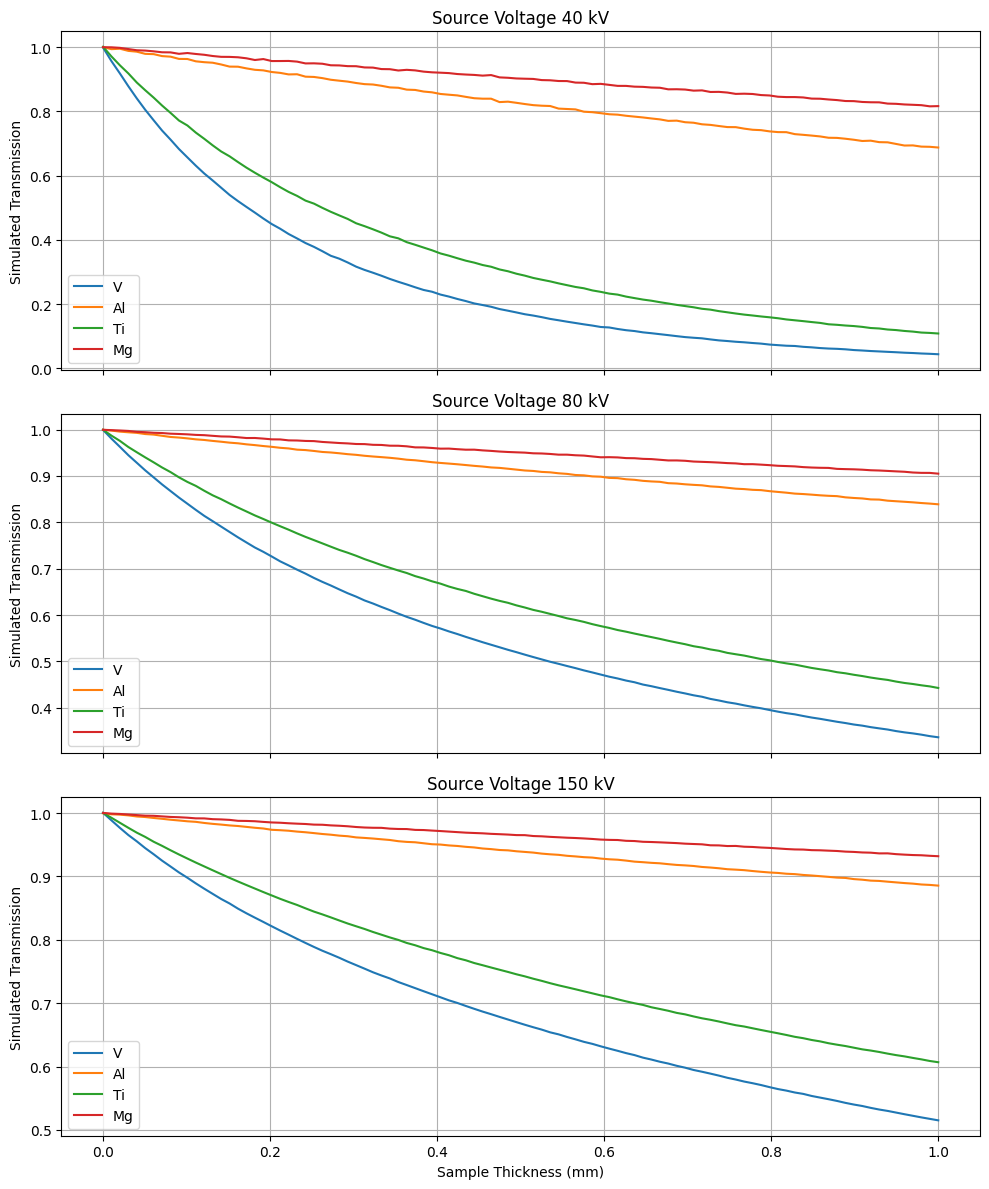

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Determine the number of cases
num_cases = len(gt_spec_list)

# Create subplots: one row per case
fig, axes = plt.subplots(nrows=num_cases, ncols=1, figsize=(10, 4 * num_cases), sharex=True)

# Ensure axes is iterable
if num_cases == 1:
    axes = [axes]

# Plot data for each case
for case_i, (ax, gt_spec) in enumerate(zip(axes, gt_spec_list)):
    for smid, sample_mat in enumerate(sample_mats):
        # Extract the transmission data for the current sample and case
        transmission_data = trans_list[case_i][100 * smid : 100 * (smid + 1)]
        ax.plot(sample_thicknesses, transmission_data, label=sample_mat)

    # Set title and labels for the subplot
    ax.set_title(f'Source Voltage {vol_list[case_i]} kV')
    ax.set_ylabel('Simulated Transmission')
    ax.grid(True)
    ax.legend()

# Set the x-axis label for the bottom subplot
axes[-1].set_xlabel('Sample Thickness (mm)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## B2. Estimation

In [11]:
from xcal.models import  Filter, Scintillator
from xcal.defs import Material
from xcal.estimate import Estimate
from T03 import Transmission_Source

learning_rate = 0.001 # 0.01 for NNAT_LBFGS and 0.001 for Adam
max_iterations = 5000 # 5000 ~ 10000 would be enough
stop_threshold = 1e-6 
optimizer_type = 'Adam' # Can also use Adam.

# For optimization, set min and max to reasonable range
sources = [Transmission_Source(
        voltage=(v, None, None),
        target_thickness=(4, 1, 7), # GT is 4.5
        single_target_thickness=True
    ) for v in vol_list]

[source.set_src_spec_list(energies_lookup, padded_spec_table, kvp_values, wth_values) for source in sources]

# Not estimate filter and scintillator
psb_fltr_mat = [Material(formula='Al', density=2.702), ]
filter_1 = Filter(psb_fltr_mat, thickness=(3, None, None))
psb_scint_mat = [Material(formula='CsI', density=4.51)]
scintillator_1 = Scintillator(materials=psb_scint_mat, thickness=(0.33, None, None))

spec_models = [[source, filter_1, scintillator_1] for source in sources]

Estimator = Estimate(ee)
# For each scan, add data and calculated forward matrix to Estimator.
for nrad, concatenate_models in zip(trans_list, spec_models):
    Estimator.add_data(nrad, spec_F, concatenate_models, weight=None)

# Fit data
Estimator.fit(learning_rate=learning_rate,
              max_iterations=max_iterations,
              stop_threshold=stop_threshold,
              optimizer_type=optimizer_type,
              loss_type='transmission',
              logpath=None,
              num_processes=1) # Parallel computing for multiple cpus.

Number of cases for different discrete parameters: 1


2025-05-25 11:47:34,144  - Start Estimation.
2025-05-25 11:47:34,171  - Initial cost: 3.992899e-06
2025-05-25 11:47:34,510  - Iteration: 50
2025-05-25 11:47:34,517  - Cost: 1.749823240970727e-06
2025-05-25 11:47:34,517  - Filter_2_material: Material(formula='Al', density=2.702)
2025-05-25 11:47:34,517  - Filter_2_thickness: 3.0
2025-05-25 11:47:34,517  - Scintillator_2_material: Material(formula='CsI', density=4.51)
2025-05-25 11:47:34,517  - Scintillator_2_thickness: 0.33000001311302185
2025-05-25 11:47:34,517  - Transmission_Source_1_voltage: 40.0
2025-05-25 11:47:34,517  - Transmission_Source_2_voltage: 80.0
2025-05-25 11:47:34,517  - Transmission_Source_3_voltage: 150.0
2025-05-25 11:47:34,517  - Transmission_Source_target_thickness: 4.273849010467529
2025-05-25 11:47:34,517  - 
2025-05-25 11:47:34,838  - Iteration: 100
2025-05-25 11:47:34,845  - Cost: 1.1709183809216483e-06
2025-05-25 11:47:34,845  - Filter_2_material: Material(formula='Al', density=2.702)
2025-05-25 11:47:34,845 

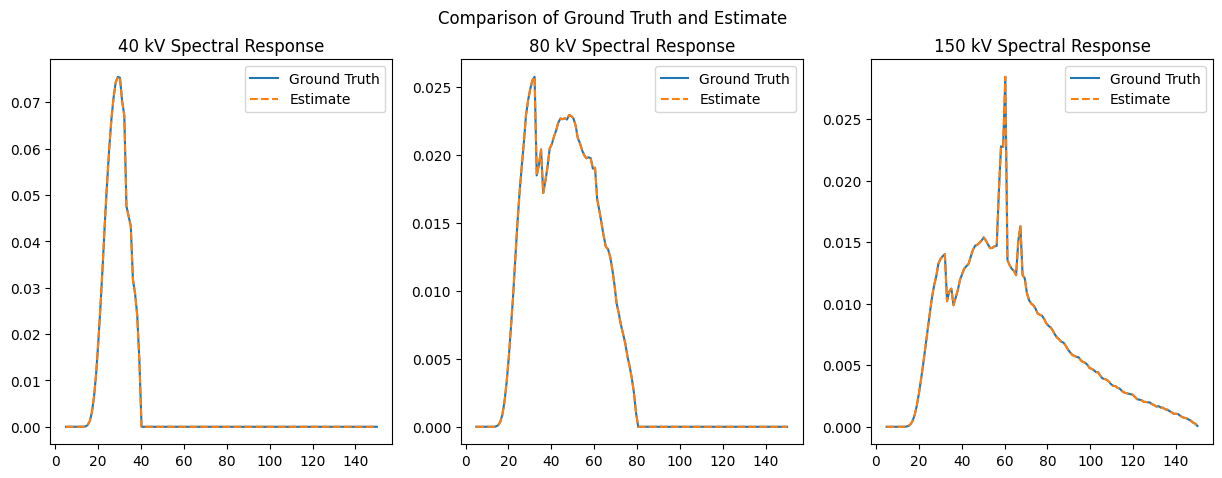

Ground Truth: 4.50, Estimated: 4.50


In [12]:
import torch
# Get the estimated effective response for each source voltage.
# Make sure to convert to numpy array from tensor before plotting.
est_sp = Estimator.get_spectra()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    with torch.no_grad():
        ax.plot(ee, (gt_spec_list[i]/np.trapezoid(gt_spec_list[i],ee)),
                label='Ground Truth')
        es = est_sp[i].numpy()
        es /= np.trapezoid(es,ee)
        ax.plot(ee, es, '--', label='Estimate')

    ax.legend()
    ax.set_title(f'{vol_list[i]} kV Spectral Response')

fig.suptitle('Comparison of Ground Truth and Estimate')
plt.show()
print(f"Ground Truth: {gt_src_tgt_th:.2f}, Estimated: {Estimator.get_params()['Transmission_Source_target_thickness'].item():.2f}")